# Toxic Comment: Topic Modelling with pyLDAvis

## The Question: What are peope talking about in our data?

The following material is inspired by jagangupta's post on Kaggle, found [here](https://www.kaggle.com/jagangupta/understanding-the-topic-of-toxicity), and [this tutorial](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/).

In this mini-project I am looking at a collection of comments from Wikipedia developer forums. Individual comments have been hand labelled as clean or toxic for the sake of making a classifier that recognizes toxic comments. This might lead to healthier, more respectful comment sections by warning or banningIP addresses that continuously post toxic comments.

Though I intend to make a project focused on the above objective sometime in the future, for now I just want to practice Topic Modelling, a subject that has caught my eye. Given that we have a collection of text data, we can see what words are used most frequently in toxic comments. After that we can focus on analyzing the text to find topics within the data.

Once we are done, we will know what words might signal a toxic comment, and what topics are common in wikipedia forums.

In [14]:
import numpy as np
import pandas as pd
import string
import warnings
warnings.filterwarnings("ignore")

#Text manipulation
from string import punctuation
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer 
import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import pyLDAvis.gensim
%matplotlib inline

#Setting NLTK constants
stop_words = stopwords.words("english")

#settings
color = sns.color_palette()

sns.set_style("dark")

warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv('C:\\Users\\harri\\.kaggle\\competitions\\jigsaw-toxic-comment-classification-challenge\\train.csv\\train.csv').fillna(' ')
test = pd.read_csv('C:\\Users\\harri\\.kaggle\\competitions\\jigsaw-toxic-comment-classification-challenge\\test.csv\\test.csv').fillna(' ')

df = pd.concat([train.iloc[:,0:2], test.iloc[:,0:2]])
df = df.reset_index(drop=True)

In [3]:
def clean(comment):
    """ This is a basic cleaner function that will remove any ugly end of line characters, wikiperdia identifying infor, and urls. 
        It will also serve as a basic preprocesser to tokenize and convert to lowercase."""
    #conv to lowercase
    comment = comment.lower()
    #replace new line
    comment = re.sub('\\n','',comment)
    #remove ip 
    comment = re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}", "",comment)
    #remove username
    comment=re.sub("\[\[.*\]","",comment)
    #remove urls
    comment = re.sub("http://.*com", '', comment)
    #article ids
    comment = re.sub("\d:\d\d\s{0,5}$", '', comment)
    #tokenizer
    comment = gensim.utils.simple_preprocess(comment, deacc=True, min_len=3)
    return comment

df['comment_text'] = df['comment_text'].apply(clean)

In [4]:
#Bigrams are words that frequently appear together in the data
bigram = gensim.models.Phrases(df.comment_text, threshold = 15)
bigram_mod = gensim.models.phrases.Phraser(bigram)
lem = WordNetLemmatizer()

In [5]:
def cleanv2(word_list, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """
    Function to further clean the pre-processed word lists 
    
    Following transformations will be done
    1) Stop words removal from the nltk stopword list
    2) Bigram collation (Finding common bigrams and grouping them together using gensim.models.phrases)
    3) Lemmatization (Converting word to its root form : babies --> baby ; children --> child)
    """
    #remove stop words
    clean_words = [w for w in word_list if not w in stop_words]
    #collect bigrams
    clean_words = bigram_mod[clean_words]
    #Lemmatize Noun
    clean_words=[lem.lemmatize(word) for word in clean_words]
    #Lemmatize Verb
    clean_words=[lem.lemmatize(word, "v") for word in clean_words]
    return clean_words  



df['comment_text'] = df['comment_text'].apply(cleanv2)

In [6]:
dictionary = Dictionary(df.comment_text)
corpus = [dictionary.doc2bow(text) for text in df.comment_text]

# Word Clouds


Here we look at the most common words in comments labelled as "Toxic. " You guessed it, its a picture full of curse words. A machine learning model might determine if a comment is toxic by looking for a high frequency of any of the words below.

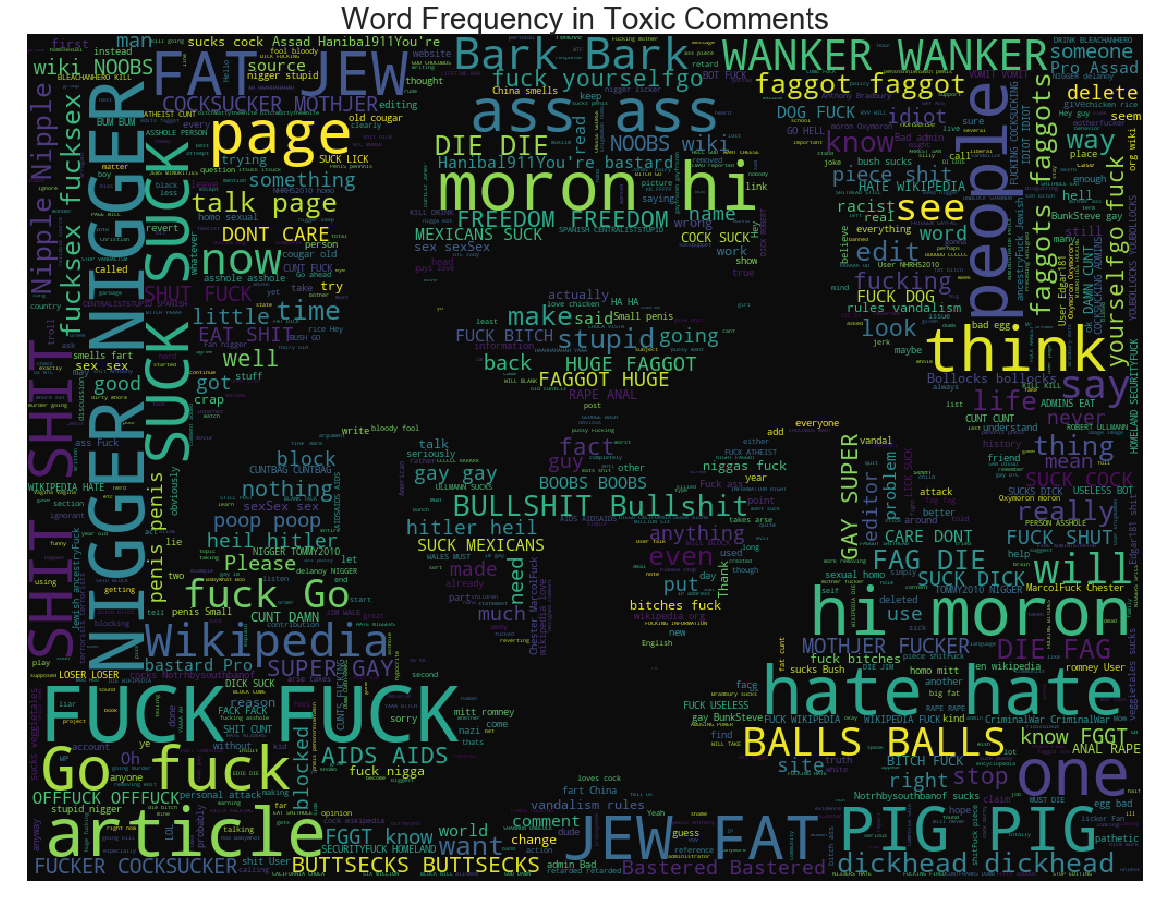

In [13]:
from PIL import Image
from wordcloud import WordCloud ,STOPWORDS

stopword = set(STOPWORDS)
clean_mask = np.array(Image.open("C:/Users/harri/Desktop/toxic2.jpg"))
clean_mask = clean_mask[:, :, 1]

subset = train[train.toxic == 1]
text = subset.comment_text.values
wc = WordCloud(background_color = "black", max_words =1000, mask = clean_mask, stopwords = stopword)
wc.generate(" ".join(text))
plt.figure(figsize = (20,20))
plt.axis("off")
plt.title("Word Frequency in Toxic Comments", fontsize = 30)
plt.imshow(wc.recolor(colormap = 'viridis', random_state = 10), alpha = 0.95)
plt.show()


# Visualization via pyLDAvis

Below is a cool interactive application via pyLDAvis. It shows the overlap of different comments topics as well as the most used words within each topic. We used the most salient words to get an understanding of what each topic might be describing.


### Visual Explanation
- On the Left we have a 2d visualization of the 50,000 + dimensional comment space.
    - Size of the circles represents the relevance of the topic within the group of comments. 
    - Bigger circle = topic words are included in more comments.
- Top 30 most salient (frequent) words within a topic are displayed on the right.


### Topic Descriptions (My Opinion)

#### Topics Relevant to Wiki Edits
- Topics 2 & 4: Wikipedia editing lingo (clean)
- Topics 7 & 10: Help sections about posting on wikipedia (clean)
- Topic 1, 3, & 5: Subjective comments on Wiki changes (clean)

#### Topics Grouping Side Conversations not About Wikipedia
- Topic 8: School, music, movies, and games (clean)
- Topic 9: Politics, Race, History (clean)
- Topic 11: Pop culture, political strife, and non wikipedia things (cleanish)

#### Toxic Topics
- Topic 6: Pure Toxicity! 
- Topics 12: Memes, Insults, and Spam 
- Topics 13 & 14: Spamming curse words and some Style Formatting

In [18]:
ldamodel = LdaModel(corpus=corpus, num_topics=14, id2word=dictionary, random_state = 100)
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.208052  0.060589       1        1  15.882286
10    -0.237674 -0.070462       2        1  13.900867
9     -0.176232  0.110696       3        1  12.192404
13    -0.204992 -0.057906       4        1  11.897571
11    -0.146316  0.164092       5        1   9.162286
12    -0.076871  0.088240       6        1   6.515952
4     -0.095627 -0.277986       7        1   5.911516
5      0.079395  0.133662       8        1   4.933044
2      0.074638  0.157780       9        1   4.725813
6     -0.020293 -0.295230      10        1   3.848903
1      0.165661  0.130283      11        1   3.407694
3      0.263237  0.011185      12        1   2.618211
8      0.289494 -0.071258      13        1   2.566616
0      0.293632 -0.083683      14        1   2.436837, topic_info=       Category           Freq                   Term          Total  loglift  \
term                                                                            
47      Default  125990.000000                article  125990.000000  30.0000   
81      Default   69573.000000              wikipedia   69573.000000  29.0000   
775     Default   31729.000000                   fuck   31729.000000  28.0000   
85      Default   61633.000000                   page   61633.000000  27.0000   
2       Default   51014.000000                   edit   51014.000000  26.0000   
11      Default   39964.000000                 please   39964.000000  25.0000   
168     Default   19076.000000                  image   19076.000000  24.0000   
29      Default   37711.000000                  thank   37711.000000  23.0000   
90      Default   47861.000000                    use   47861.000000  22.0000   
203     Default   33108.000000                 source   33108.000000  21.0000   
404     Default   35346.000000                    get   35346.000000  20.0000   
3466    Default    9459.000000              fuck_fuck    9459.000000  19.0000   
16      Default   19276.000000              talk_page   19276.000000  18.0000   
210525  Default   11653.000000               wtf_omfg   11653.000000  17.0000   
458     Default   17526.000000                   help   17526.000000  16.0000   
67      Default   16374.000000              reference   16374.000000  15.0000   
1647    Default   20516.000000                   user   20516.000000  14.0000   
131     Default   28434.000000                    add   28434.000000  13.0000   
180     Default   20345.000000                   link   20345.000000  12.0000   
593     Default   17511.000000                  block   17511.000000  11.0000   
70      Default   21108.000000                section   21108.000000  10.0000   
301     Default   46667.000000                    say   46667.000000   9.0000   
277     Default   43571.000000                   like   43571.000000   8.0000   
41277   Default    7450.000000              cunt_cunt    7450.000000   7.0000   
38      Default   17293.000000            information   17293.000000   6.0000   
1633    Default   17911.000000                 editor   17911.000000   5.0000   
268     Default   18135.000000             discussion   18135.000000   4.0000   
736     Default   32445.000000                 people   32445.000000   3.0000   
752     Default   10324.000000                welcome   10324.000000   2.0000   
769     Default   19551.000000                comment   19551.000000   1.0000   
...         ...            ...                    ...            ...      ...   
8754    Topic14    1161.054688                 hitler    1161.961548   3.7137   
81932   Topic14     868.134766          wanker_wanker     869.041626   3.7134   
100     Topic14     817.090332                 animal     817.997314   3.7134   
9515    Topic14     666.264648                    fag     667.171509   3.7131   
317539  Topic14    1328.742310              hole_phck    1330.584351   3.7131   
5869    Topic14